In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from torch import nn # nn contains all of PyTorch's building blocks of neural networks
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

/home/user/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def categorize(dataframe):
    a_values = dataframe['unitcell_a'].values
    b_values = dataframe['unitcell_b'].values
    alpha_values = dataframe['unitcell_alpha'].values
    beta_values = dataframe['unitcell_beta'].values
    gamma_values = dataframe['unitcell_gamma'].values
    categories = []
    for i in range(len(a_values)):
        a_equals_b = round(a_values[i], 2) == round(b_values[i], 2)
        gamma_equals_90 = 80 <= gamma_values[i] <= 100
        gamma_equals_60 = 50 <= gamma_values[i] <= 70
        gamma_equals_120 = 110 <= gamma_values[i] <= 130
        
        if a_equals_b:
            if gamma_equals_90:
                categories.append('Square')
            elif gamma_equals_60 or gamma_equals_120:
                categories.append('Hexagonal')
            else:
                categories.append('Uncategorized')
                
        else:
            if gamma_equals_90:
                categories.append('Rectangular')
            else:
                categories.append('Uncategorized')
                
    return categories

In [3]:
df = pd.read_csv("data_8.csv")
external_df = pd.read_csv("external_test.csv")
len(df)

236

In [4]:
# Dropping Duplicate Data

systems_to_drop = ['CEY', 'GY1']
df = df[~df['system'].isin(systems_to_drop)]

len(df)

234

In [5]:
df = df.loc[(df["alpha_300"] > -50) & (df['alpha_300'] < 50)]

In [6]:
len(df)

213

In [7]:
df["types_of_bond_angle_per_bond"] = df["types_of_bond_angle"].values / df["bond_types"].values
external_df["types_of_bond_angle_per_bond"] = external_df["types_of_bond_angle"].values / external_df["bond_types"].values

In [8]:
alpha_max_pred  = pd.read_csv("nte_max_pred.csv")

In [9]:
df = df.merge(alpha_max_pred, how='inner', on='system')

In [10]:
df

,system,number_density,atom_types,unitcell_alpha,unitcell_beta,unitcell_gamma,unitcell_a,unitcell_b,unitcell_c,density,...,spin_orbit_coupling,oxidation,entropy,linear_centre_fraction,alpha_max,alpha_max_temperature,alpha_300,saruration,types_of_bond_angle_per_bond,predicted_nte_max
0,MoSe2,0.0315,2,90,90,60,3.3174,3.3174,10.0,2.6651,...,3111696,6,5.291979,0.0,-0.129205,10,19.879219,20,4.000000,0.876559
1,blue-P,0.0217,1,90,90,120,3.2621,3.2621,10.0,0.6728,...,50625,0,0.000000,0.0,-10.253350,60,8.648487,180,1.000000,9.855130
2,c63,0.0347,1,90,90,60,6.3156,6.3156,10.0,0.4169,...,1296,0,0.000000,0.0,-7.452979,220,-6.978796,1000,1.500000,8.379861
3,twin-graphene,0.0551,1,90,90,120,6.1417,6.1417,10.0,0.6612,...,1296,0,0.000000,0.0,-1.700107,790,8.271276,10,1.333333,0.580249
4,alpha-α-C2As2,0.0482,2,90,90,60,3.0968,3.0968,10.0,2.0951,...,1185921,0,5.762826,0.0,-0.582627,30,11.851636,50,1.000000,0.519728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,AsGD-REC,0.0175,2,90,90,90,9.0955,17.5495,10.0,0.3684,...,1185921,0,3.409707,0.0,-7.950141,20,8.959853,110,1.000000,3.805382
184,beta-β-Sn2P2,0.0305,2,90,90,60,3.8932,3.8932,10.0,2.2855,...,6250000,3,5.762826,0.0,-7.420966,50,8.184467,140,1.000000,7.722475
185,6.6.6-GY,0.0292,1,90,90,90,6.8844,11.9243,10.0,0.3508,...,1296,0,0.000000,0.0,-10.809670,210,-9.881993,1000,1.000000,11.442291
186,AlGD-HEX,0.0093,2,90,90,60,13.1815,13.1814,10.0,0.1316,...,28561,3,3.409707,0.0,-15.337266,50,-1.256259,940,0.666667,10.717804


In [11]:
len(df)

188

0.5887559624653569


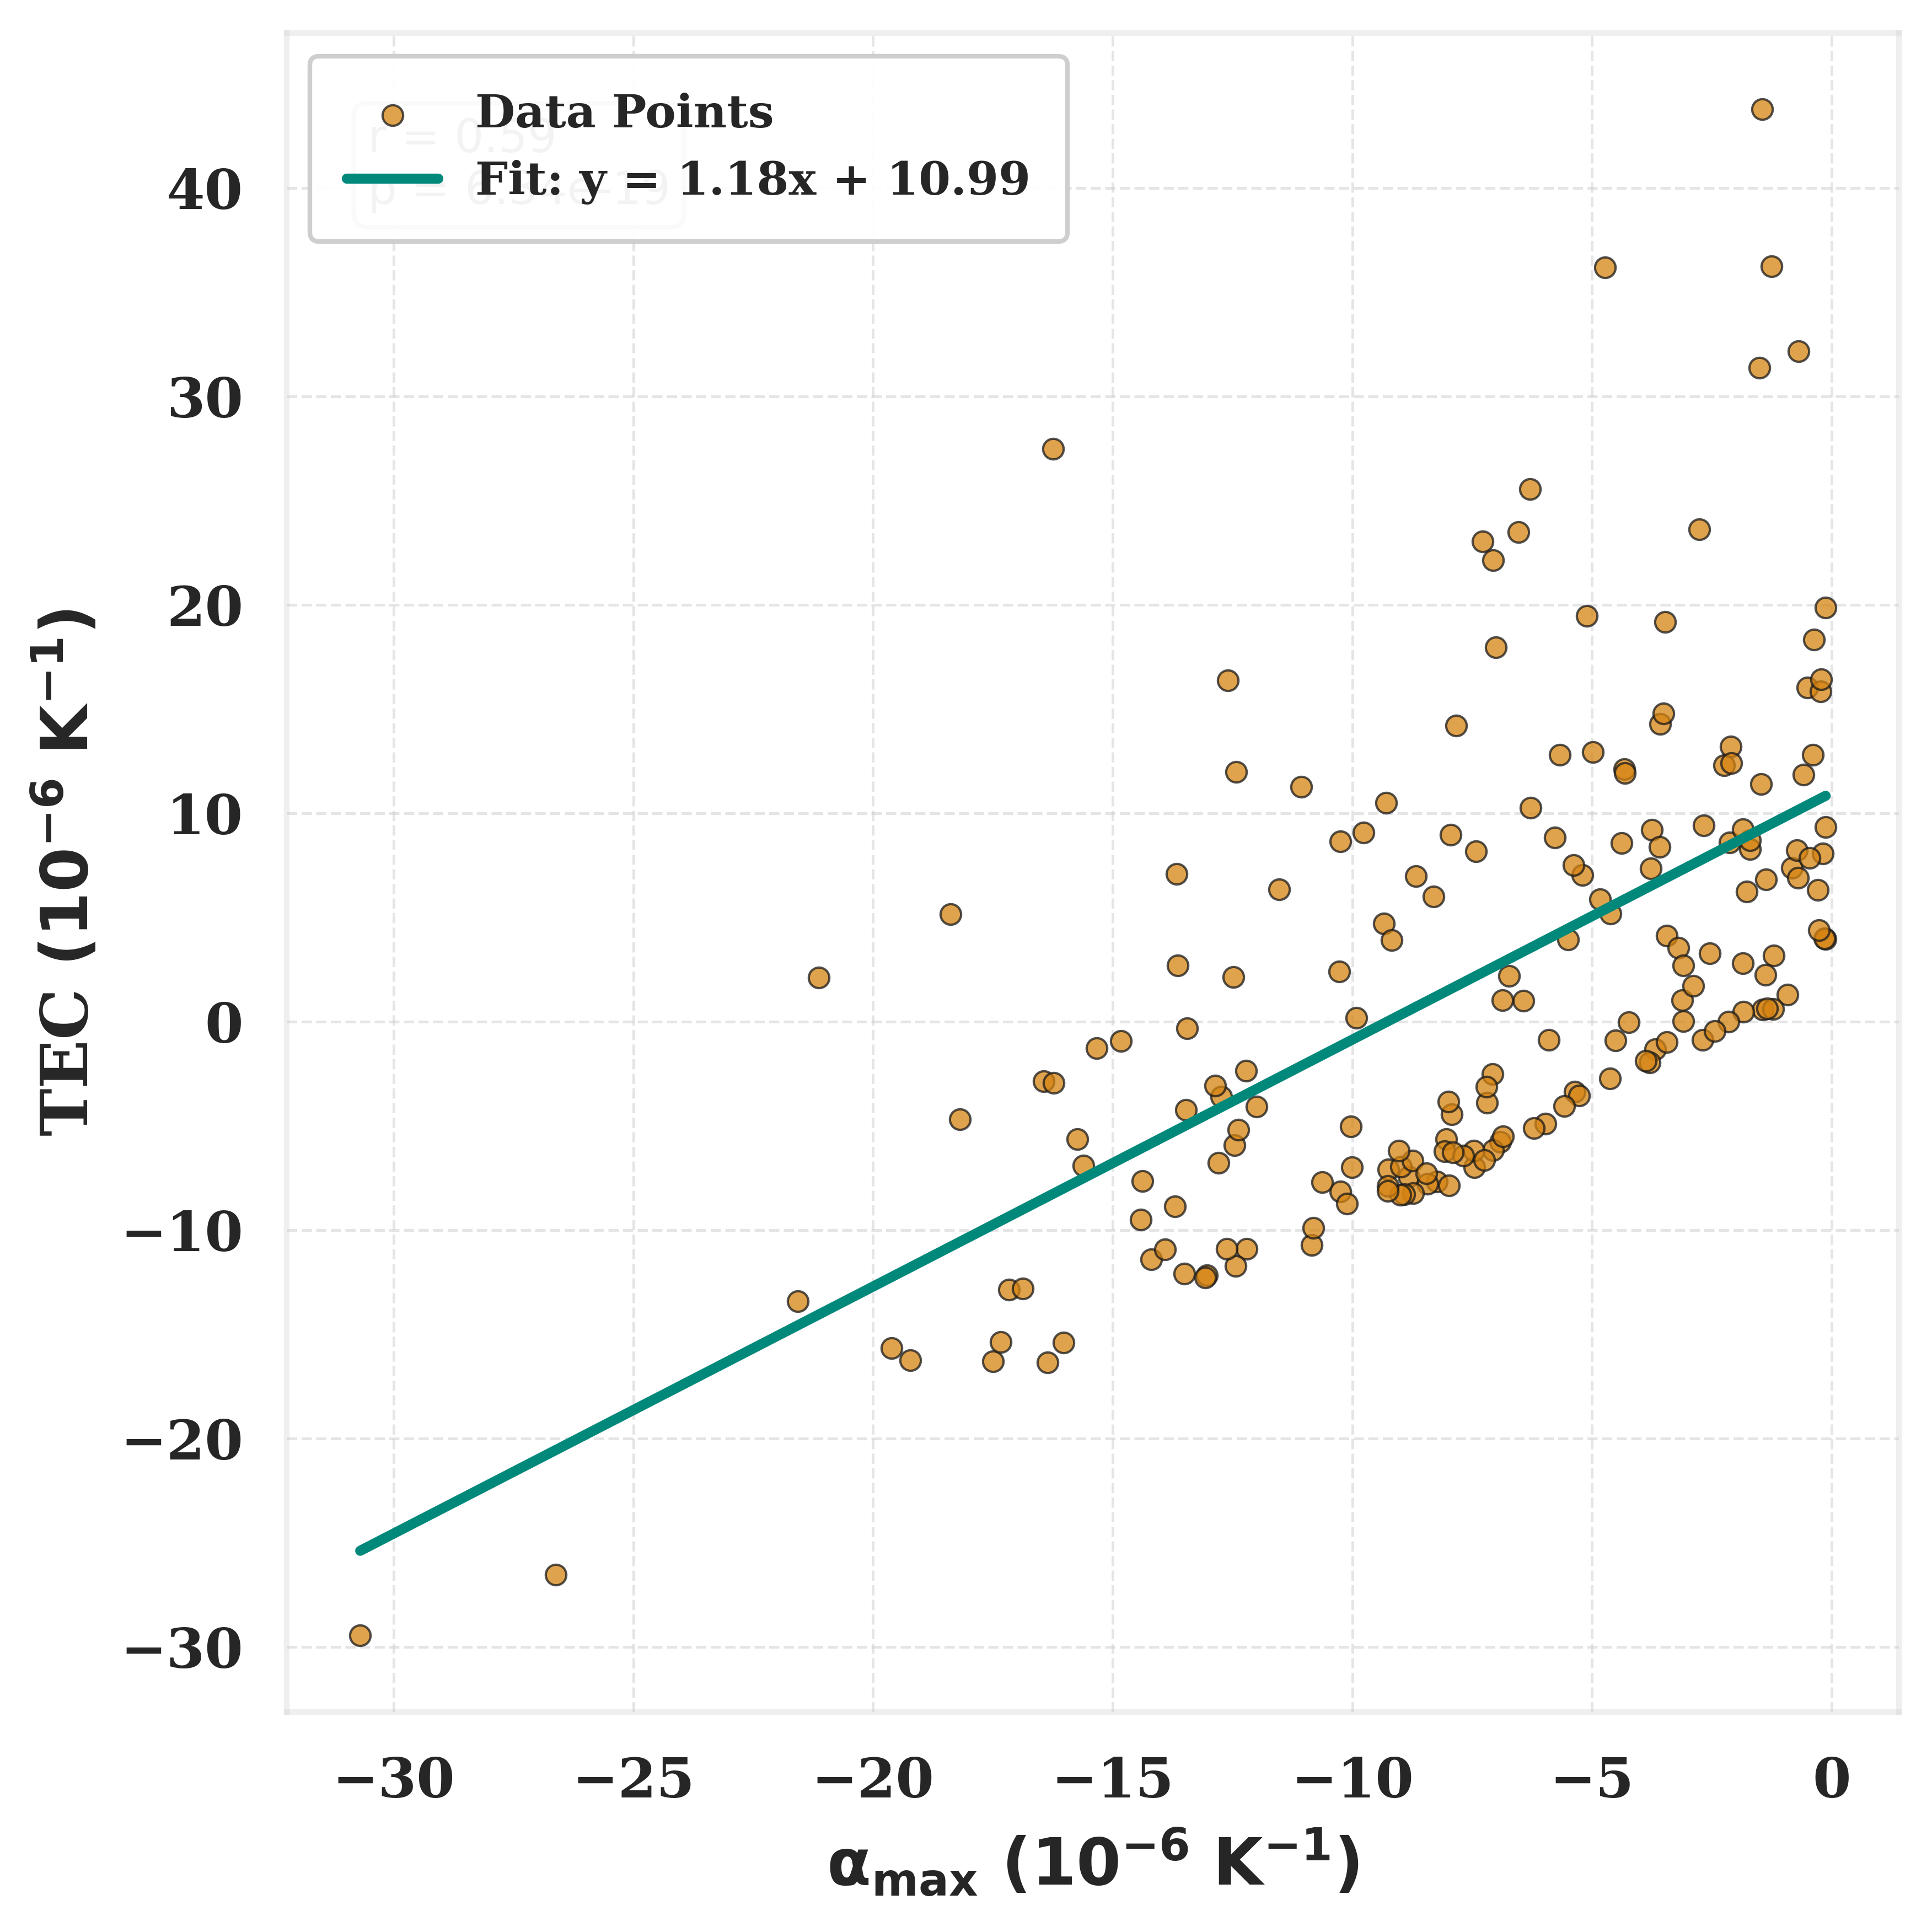

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

# Seaborn style
sns.set(style="whitegrid")

# Data
x = df["alpha_max"].values
y = df["alpha_300"].values

# Pearson correlation
r, p_value = pearsonr(x, y)
print(r)

# Fit line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Figure
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

# Scatter plot (Vivid Orange)
ax.scatter(
    x, y,
    color="#d68411",        # Vivid orange
    edgecolor="k",
    alpha=0.75,
    s=20,
    linewidth=0.5,
    label="Data Points"
)

# Trendline (Deep Teal)
ax.plot(
    np.sort(x), p(np.sort(x)),
    color="#00897B",        # Deep teal
    linewidth=2.2,
    label=f"Fit: y = {z[0]:.2f}x + {z[1]:.2f}"
)

# Labels and title
ax.set_xlabel(r"$\mathbf{\alpha_{max}}$ " + r"$\mathbf{(10^{-6}\ K^{-1})}$", 
              fontsize=14, 
              fontweight='bold', 
              fontfamily='serif')
ax.set_ylabel("TEC " + r"$\mathbf{(10^{-6}\ K^{-1})}$", 
              fontsize=14, 
              fontweight='bold', 
              fontfamily='serif')

# Grid
ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)

# Legend
legend = ax.legend(
    loc="upper left",
    fontsize=10,
    frameon=True,
    framealpha=0.95,
    borderpad=0.8
)

for text in legend.get_texts():
    text.set_fontfamily('serif')     # or 'Times New Roman', etc.
    text.set_fontweight('bold')
    text.set_fontstyle('normal')     # optional: italic, normal, oblique

for text in ax.get_yticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# Subtle spines
for spine in ax.spines.values():
    spine.set_alpha(0.3)

# Annotate correlation
ax.annotate(
    f"r = {r:.2f}\np = {p_value:.2e}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    fontsize=10,
    ha="left", va="top",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.6)
)

# Final layout
plt.tight_layout()
plt.savefig("correlation.svg", dpi=600, bbox_inches='tight')
plt.show()

In [13]:
train_labels = np.array(['PGY-REC', 'BPC', 'alpha-α-Sn2As2', 'pentaheptite', 'GY2',
       'C8N2-2', 'c65', 'SnP3', 'BN', 'c14n12', 'AlGD-REC', 'c10n9',
       'beta12_borophene', 'IGP-P-S', 'alpha-α-Si2Sb2',
       'H5', 'theta_P', 'BGD-HEX', 'alpha-α-C2As2', 'DHPP-S', 'C3N2',
       'TPH-graphene', 'WS2', 'oblique-heackelite', 'GaSb',
       'alpha-α-Ge2Bi2', 'BC6N-Rec', 'Pha', 'AlP',
       'beta-β-Si2As2', 'PAI-graphene', 'alpha-α-Ge2As2', 'BGY-REC',
       'pentahexoctite', 'net_C', 'beta-β-Si2Sb2', 'graphene', 'PGD-REC',
       'alpha-α-Si2As2', 'Si2As2', 'beta-BC2N', 'net_W',
       'AlN', 'squarographene', 'DBP', 'BP', '17', 'delta-gy',
       'DHP-graphene', 'GaGY-HEX', 'AlGY-HEX', 'beta-β-Pb2P2',
       'twin-graphene', 'AsGD-HEX', 'BaAs3', 'c18n8', 'c41',
       'CaP3', 'AlBi', 'GDY-2', '1', 'PBN', 'GDY', 'biphenylene',
       's-graphene', 'As2Se3', 'TPHHO-graphene', 'HOP-graphene',
       'chi3_borophene', 'c10N3', 'WSe2', 'C9N4', 'Fused_pentagon',
       'germanene', 'OPG-L', 'AlGD-HEX', 'beta-β-Ge2Bi2', 'NGY-HEX',
       'lambda-GY', 'C4N3', 'DHQ_graphene', 'NGY-REC', 'Pb2P2',
       'beta-β-Sn2P2', 'alpha-α-Ge2N2', 'borophene-2', 'GY3', 'C12N2',
       'ZW-21', 'C2N', 'alpha-α-Si2Bi2', 'THD-graphene', 'Ge2Sb2', 'C2P2',
       'BC6N-Hex2', 'alpha-α-Pb2P2', 'blue-P', 'GaGD-HEX', 'OPG-Z',
       'Sn2N2', 'BGD-REC', 'C2Sb2', 'InAs',
       'PHE-graphene', 'GaGY-REC', 'hexagonal-heackelite', 'NGD-REC', 'AsGY-REC',
       '14.14.14-GY', 'beta-GY', '10', 'beta-β-Si2Bi2', 'BSb', '6', "Si2P2",
       'T_graphene'], dtype=object)

In [14]:
test_labels = np.array(['alpha-α-Si2P2', 'MoSe2', 'gamma-BC2N', 'borophene_hole', 'PHH-graphene', 
                       'pza_c10', 'alpha-Gy', '14.14.18-GY', 'H3', 'molybdenene', 'H2', 
                       'beta-β-Ge2N2', 'BC3', 'beta-β-Sn2N2', 'CN', 'beta-β-C2P2', 'GaP', 
                       'BC10N2', 'C4N-2', '4', 'H1', 'arsenene', '12', 
                       'tri_graphene', 'H4', 'BC6N-Hex', 'beta-β-Si2P2', 'PCF-graphene', 
                       'rec-heackelite', 'C3N', '11', '7', 'C36N6', 'PGD-HEX', 
                       'Si2Bi2', '18.18.18-Gy', 'InBi', 'c63',
                       'Penta-graphene', 'alpha-α-Sn2N2', 'GaGD-REC', 'alpha-α-Ge2P2', 'Sn2As2', 'beta-β-Ge2As2', 
                        'gamma-Gy', 'black-P', 'B2_P', 'eta_P', 'B2N2', 'BCN-1', 
                        '5', 'BC6N6', '14', 'beta-β-Sn2As2', '8', 
                        'C8N2', 'silicene', 'beta-β-Ge2P2', 'MoS2', 
                        'alpha-BC2N', 'phagraphene', '15', 'azugraphene', 'C7N6', '6.6.6-GY', 
                        'C3N5', 'alpha-α-Sn2P2', 'alpha-α-Sn2Sb2', '2', 'AsGD-REC', '13', 
                        '6.6.12-Gy', '16', '9', 'BGY-HEX', "Pb2N2"
                      ])

In [15]:
nte_max_val_labels = np.array(['alpha-α-Si2P2', 'MoSe2', 'gamma-BC2N', 'borophene_hole', 'PHH-graphene', 
                       'pza_c10', 'alpha-Gy', '14.14.18-GY', 'H3', 'molybdenene', 'H2', 
                       'beta-β-Ge2N2', 'BC3', 'beta-β-Sn2N2', 'CN', 'beta-β-C2P2', 'GaP', 
                       'BC10N2', 'C4N-2', '4', 'H1', 'arsenene', '12', 
                       'tri_graphene', 'H4', 'BC6N-Hex', 'beta-β-Si2P2', 'PCF-graphene', 
                       'rec-heackelite', 'C3N', '11', '7', 'C36N6', 'PGD-HEX', 
                       'Si2Bi2', '18.18.18-Gy', 'InBi', 'c63',
                       'Penta-graphene', 'alpha-α-Sn2N2', 'GaGD-REC', 'alpha-α-Ge2P2', 'Sn2As2', 'beta-β-Ge2As2', 
                        'gamma-Gy', 'black-P', 'B2_P', 'eta_P', 'B2N2', 'BCN-1', 
                        '5', 'BC6N6', '14', 'beta-β-Sn2As2', '8', 
                        'C8N2', 'silicene', 'beta-β-Ge2P2', 'MoS2', 
                        'alpha-BC2N', 'phagraphene', '15', 'azugraphene', 'C7N6', '6.6.6-GY', 
                        'C3N5', 'alpha-α-Sn2P2', 'alpha-α-Sn2Sb2', '2', 'AsGD-REC', '13', 
                        '6.6.12-Gy', '16', '9', 'BGY-HEX', "Pb2N2"
                      ])

In [16]:
intersection = np.intersect1d(nte_max_val_labels, train_labels)
print(intersection)

[]


In [17]:
intersection = np.intersect1d(train_labels, test_labels)
print(intersection)

[]


In [18]:
df["basis"] = categorize(df)
external_df['basis'] = categorize(external_df)

In [19]:
df.reset_index(drop=True, inplace=True)

In [20]:
columns_to_encode = ["basis"]

# OneHotEncoder instance
encoder = OneHotEncoder(sparse_output=False, drop=None)

# Fit and transform the columns to be encoded
encoded_data = encoder.fit_transform(df[columns_to_encode])
external_encoded_data = encoder.transform(external_df[columns_to_encode])

# Get the new column names
encoded_column_names = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)
external_encoded_df = pd.DataFrame(external_encoded_data, columns=encoded_column_names)

In [21]:
len(encoded_df), len(df)

(188, 188)

In [22]:
# Concatenate the encoded columns back with the original DataFrame
df = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)
external_df = pd.concat([external_df.drop(columns=columns_to_encode), external_encoded_df], axis=1)

# Display the encoded DataFrame
df

,system,number_density,atom_types,unitcell_alpha,unitcell_beta,unitcell_gamma,unitcell_a,unitcell_b,unitcell_c,density,...,alpha_max,alpha_max_temperature,alpha_300,saruration,types_of_bond_angle_per_bond,predicted_nte_max,basis_Hexagonal,basis_Rectangular,basis_Square,basis_Uncategorized
0,MoSe2,0.0315,2,90,90,60,3.3174,3.3174,10.0,2.6651,...,-0.129205,10,19.879219,20,4.000000,0.876559,1.0,0.0,0.0,0.0
1,blue-P,0.0217,1,90,90,120,3.2621,3.2621,10.0,0.6728,...,-10.253350,60,8.648487,180,1.000000,9.855130,1.0,0.0,0.0,0.0
2,c63,0.0347,1,90,90,60,6.3156,6.3156,10.0,0.4169,...,-7.452979,220,-6.978796,1000,1.500000,8.379861,1.0,0.0,0.0,0.0
3,twin-graphene,0.0551,1,90,90,120,6.1417,6.1417,10.0,0.6612,...,-1.700107,790,8.271276,10,1.333333,0.580249,1.0,0.0,0.0,0.0
4,alpha-α-C2As2,0.0482,2,90,90,60,3.0968,3.0968,10.0,2.0951,...,-0.582627,30,11.851636,50,1.000000,0.519728,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,AsGD-REC,0.0175,2,90,90,90,9.0955,17.5495,10.0,0.3684,...,-7.950141,20,8.959853,110,1.000000,3.805382,0.0,1.0,0.0,0.0
184,beta-β-Sn2P2,0.0305,2,90,90,60,3.8932,3.8932,10.0,2.2855,...,-7.420966,50,8.184467,140,1.000000,7.722475,1.0,0.0,0.0,0.0
185,6.6.6-GY,0.0292,1,90,90,90,6.8844,11.9243,10.0,0.3508,...,-10.809670,210,-9.881993,1000,1.000000,11.442291,0.0,1.0,0.0,0.0
186,AlGD-HEX,0.0093,2,90,90,60,13.1815,13.1814,10.0,0.1316,...,-15.337266,50,-1.256259,940,0.666667,10.717804,1.0,0.0,0.0,0.0


In [23]:
df.drop(columns=[
                 'alpha_max_temperature', 
                 'alpha_max',
                 'saruration',
                 'energy',
                 # 'mean_bond_length',
                 'pointgroup',
                 'mean_bond_angle',
                 # 'mean_coordination',
                 'density',
                 # 'atom_types',
                 'effective_electronegativity',
                 'electronegativity',
                 'largest_pore_radius',
                 # 'bond_types',
                 # 'types_of_bond_angle',
                 'reduced_mass',
                 'packing_fraction',
                 'unitcell_alpha', 'unitcell_beta',
                 'unitcell_gamma',
                 'unitcell_a', 'unitcell_b',
                 'unitcell_c',
                 'max_puckering',
                 'number_density',
                 'bond_variance',
                 'bond_std',
                 'angle_variance',
                 'std_angle',
                 # 'types_puckering',
                 # 'mean_puckering',
                 # 'z_variance',
                 # 'symmetry_number',
                 'average_mass',
                 'bond_strain',
                 # 'bond_density',
                 'num_layers',
                 'layer_width',
                 # 'oxidation',
                 # 'entropy',
                 'types_of_bond_angle_per_bond',
                 'linear_centre_fraction',
                 'spin_orbit_coupling',
                 'basis_Hexagonal',
                 'basis_Rectangular',
                 'basis_Square', 
                 'basis_Uncategorized'
                ], inplace=True)

In [24]:
external_df.drop(columns=[
                 'alpha_max_temperature', 
                 'alpha_max',
                 'saruration',
                 'energy',
                 # 'mean_bond_length',
                 'pointgroup',
                 'mean_bond_angle',
                 # 'mean_coordination',
                 'density',
                 # 'atom_types',
                 'effective_electronegativity',
                 'electronegativity',
                 'largest_pore_radius',
                 # 'bond_types',
                 # 'types_of_bond_angle',
                 'reduced_mass',
                 'packing_fraction',
                 'unitcell_alpha', 'unitcell_beta',
                 'unitcell_gamma',
                 'unitcell_a', 'unitcell_b',
                 'unitcell_c',
                 'max_puckering',
                 'number_density',
                 'bond_variance',
                 'bond_std',
                 'angle_variance',
                 'std_angle',
                 # 'types_puckering',
                 # 'mean_puckering',
                 # 'z_variance',
                 # 'symmetry_number',
                 'average_mass',
                 'bond_strain',
                 # 'bond_density',
                 'num_layers',
                 'layer_width',
                 # 'oxidation',
                 # 'entropy',
                 'types_of_bond_angle_per_bond',
                 'linear_centre_fraction',
                 'spin_orbit_coupling',
                 'basis_Hexagonal',
                 'basis_Rectangular',
                 'basis_Square', 
                 'basis_Uncategorized'
                ], inplace=True)

In [25]:
df.columns

Index(['system', 'atom_types', 'mean_coordination', 'bond_types',
       'mean_bond_length', 'types_of_bond_angle', 'symmetry_number',
       'types_puckering', 'mean_puckering', 'bond_density', 'z_variance',
       'oxidation', 'entropy', 'alpha_300', 'predicted_nte_max'],
      dtype='object')

In [26]:
external_df.columns

Index(['system', 'atom_types', 'mean_coordination', 'bond_types',
       'mean_bond_length', 'types_of_bond_angle', 'symmetry_number',
       'types_puckering', 'mean_puckering', 'bond_density', 'z_variance',
       'oxidation', 'entropy', 'alpha_300', 'predicted_nte_max'],
      dtype='object')

In [27]:
train_df = df.loc[df["system"].isin(train_labels)]
test_df = df.loc[df["system"].isin(test_labels)]

In [28]:
feature_names = list(train_df.columns)

In [29]:
train_labels = train_df["system"].values
test_labels = test_df["system"].values

In [30]:
intersection = np.intersect1d(train_labels, test_labels)
print(intersection)

[]


In [31]:
X_train = train_df.drop(columns=["system", "alpha_300"])
feature_names = X_train.columns
X_train = X_train.values
y_train = train_df["alpha_300"].values

In [32]:
X_test = test_df.drop(columns=["system", "alpha_300"]).values
y_test = test_df["alpha_300"].values

In [33]:
X_external = external_df.drop(columns=[ 'system', 'alpha_300']).values
y_external = external_df['alpha_300'].values

In [34]:
len(y_train), len(y_test)

(113, 75)

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_external = scaler.transform(X_external)

In [36]:
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
X_external = torch.from_numpy(X_external).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)
y_external = torch.from_numpy(y_external).type(torch.float)

In [37]:
torch.manual_seed(1)

class Model(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_layers),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_layers, out_features=out_features)
        )
        
    def forward(self, x):
        return self.layer_stack(x)
    
model = Model(in_features=X_train.shape[1], out_features=1, hidden_layers=16)
model

Model(
  (layer_stack): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [38]:
class BerHuLoss(nn.Module):
    def __init__(self, delta=None):
        super(BerHuLoss, self).__init__()
        self.delta = delta  # If None, we can set it dynamically later if you want

    def forward(self, y_pred, y_true):
        error = y_pred - y_true
        abs_error = torch.abs(error)

        if self.delta is None:
            # Optionally, you can set delta automatically based on the batch
            delta = 0.2 * torch.max(abs_error).item()  # 20% of max error
        else:
            delta = self.delta

        # Small errors: use L1
        l1_part = abs_error

        # Big errors: use scaled L2
        l2_part = (error ** 2 + delta ** 2) / (2 * delta)

        # Condition: use l1 if abs_error <= delta, else l2
        loss = torch.where(abs_error <= delta, l1_part, l2_part)

        return loss.mean()

In [39]:
# Setup a loss function 
loss_fn = nn.MSELoss()
# loss_fn = nn.HuberLoss(delta=9.0)

# Setup a optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-1, lr=0.001)

In [40]:
train_losses = []
valid_losses = []

torch.manual_seed(42)
epochs = 1700

for epoch in range(epochs):
    model.train()
    
    # 1. Forward
    y_pred = model(X_train).squeeze()
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Backpropagation
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test).squeeze()
        
        test_loss = loss_fn(test_pred, y_test)
    
    train_losses.append(loss.item())
    valid_losses.append(test_loss.item())
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
        print("="*100)

print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 125.44375 | Test Loss: 143.75687
Epoch: 100 | Loss: 108.91876 | Test Loss: 124.59633
Epoch: 200 | Loss: 64.50085 | Test Loss: 76.64441
Epoch: 300 | Loss: 40.50901 | Test Loss: 42.94388
Epoch: 400 | Loss: 37.62878 | Test Loss: 38.22061
Epoch: 500 | Loss: 35.43097 | Test Loss: 35.31452
Epoch: 600 | Loss: 34.15993 | Test Loss: 32.61010
Epoch: 700 | Loss: 33.01931 | Test Loss: 30.88932
Epoch: 800 | Loss: 32.20145 | Test Loss: 30.02018
Epoch: 900 | Loss: 31.64877 | Test Loss: 29.33024
Epoch: 1000 | Loss: 31.09979 | Test Loss: 28.67525
Epoch: 1100 | Loss: 30.52395 | Test Loss: 28.12365
Epoch: 1200 | Loss: 29.95314 | Test Loss: 27.82087
Epoch: 1300 | Loss: 29.27015 | Test Loss: 27.17527
Epoch: 1400 | Loss: 28.50105 | Test Loss: 27.12197
Epoch: 1500 | Loss: 27.63496 | Test Loss: 27.15074
Epoch: 1600 | Loss: 26.95653 | Test Loss: 26.94148
Epoch: 1699 | Loss: 26.12675 | Test Loss: 27.24506


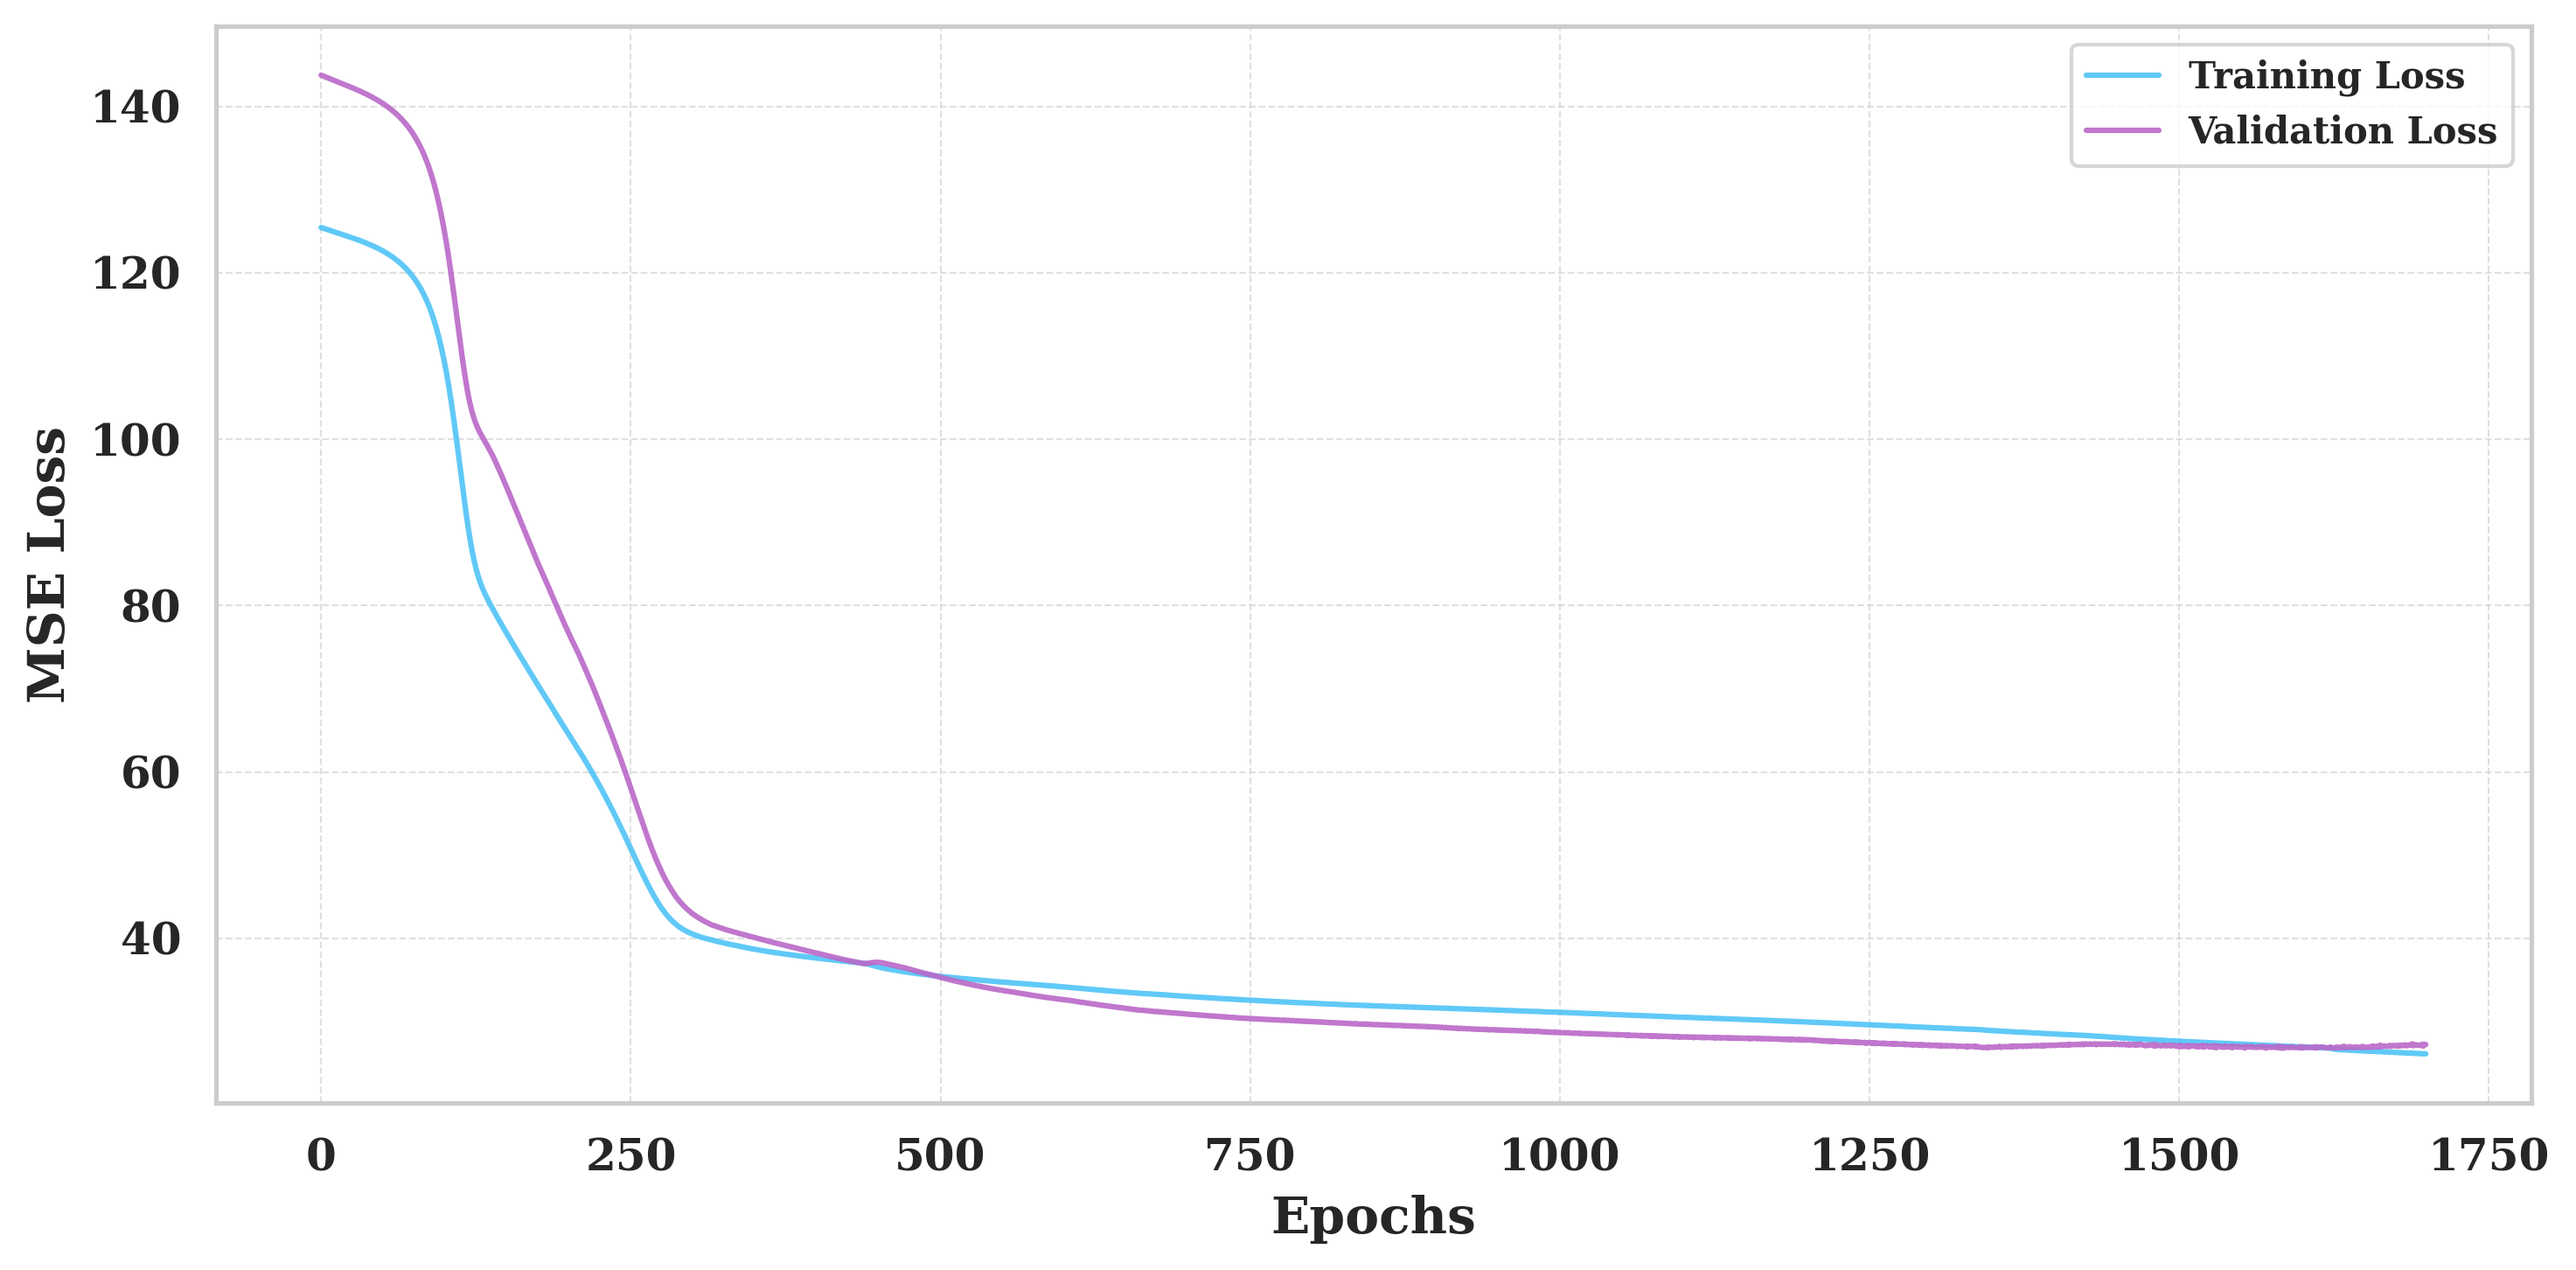

In [41]:
# Use a clean style
sns.set(style="whitegrid")

# Create figure
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Plot lines only — no markers
ax.plot(range(epochs), train_losses, label="Training Loss",
        color="#4fc3f7", linewidth=1.5, alpha=0.9)

ax.plot(range(epochs), valid_losses, label="Validation Loss",
        color="#ba68c8", linewidth=1.5, alpha=0.9)


for text in ax.get_yticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# Labels and Title
ax.set_xlabel("Epochs", fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel("MSE Loss", fontsize=14, fontweight='bold', fontfamily='serif')


# Grid and legend
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
legend = ax.legend(fontsize=10)

for text in legend.get_texts():
    text.set_fontfamily('serif')
    text.set_fontweight('bold')
    text.set_fontstyle('normal')  

# Tight layout and save
plt.tight_layout()
plt.savefig("nn_learning_curve_tec.svg", bbox_inches="tight")
plt.savefig("nn_learning_curve_tec.png", dpi=600, bbox_inches="tight")
plt.show()

In [42]:
model.eval()
with torch.inference_mode():
    y_train_pred = model(X_train).squeeze()
    y_pred = model(X_test).squeeze()
    y_external_pred = model(X_external).squeeze()

In [43]:
y_pred = y_pred.numpy()
y_test = y_test.numpy()

In [44]:
y_train = y_train.numpy()
y_train_pred = y_train_pred.numpy()

In [45]:
y_external_pred = y_external_pred.numpy()
y_external_pred

array([34.77665  , 21.233044 , 23.150885 ,  3.9424539, -6.6506844,
       31.152744 , -7.556199 , -7.1422033], dtype=float32)

In [46]:
print("R2 Score: ", round(r2_score(y_train, y_train_pred), 2))
print("Mean Absolute Error: ", round(mean_absolute_error(y_train, y_train_pred), 2))
print("Mean Absolute Percentage Error: ", round(mean_absolute_percentage_error(y_train, y_train_pred), 2))
print("Root Mean Squared Error: ", round(root_mean_squared_error(y_train, y_train_pred), 2))

R2 Score:  0.79
Mean Absolute Error:  3.69
Mean Absolute Percentage Error:  6.71
Root Mean Squared Error:  5.11


In [47]:
print("R2 Score: ", round(r2_score(y_test, y_pred), 3))
print("Mean Absolute Error: ", round(mean_absolute_error(y_test, y_pred), 2))
print("Mean Absolute Percentage Error: ", round(mean_absolute_percentage_error(y_test, y_pred), 2))
print("Root Mean Squared Error: ", round(root_mean_squared_error(y_test, y_pred), 2))

R2 Score:  0.802
Mean Absolute Error:  3.9
Mean Absolute Percentage Error:  1.38
Root Mean Squared Error:  5.22


In [48]:
y_true = np.hstack([y_train, y_test])
y_forecast = np.hstack([y_train_pred, y_pred])

print("R2 Score: ", round(r2_score(y_true, y_forecast), 2))
print("Mean Absolute Error: ", round(mean_absolute_error(y_true, y_forecast), 2))
print("Mean Absolute Percentage Error: ", round(mean_absolute_percentage_error(y_true, y_forecast), 2))
print("Root Mean Squared Error: ", round(root_mean_squared_error(y_true, y_forecast), 2))

R2 Score:  0.79
Mean Absolute Error:  3.77
Mean Absolute Percentage Error:  4.58
Root Mean Squared Error:  5.15


In [49]:
labels = []
true_values = []
pred_values = []
for label, true_value, pred_value in list(zip(train_labels, y_train, y_train_pred)):
    labels.append(label)
    true_values.append(true_value)
    pred_values.append(pred_value)

for label, true_value, pred_value in list(zip(test_labels, y_test, y_pred)):
    labels.append(label)
    true_values.append(true_value)
    pred_values.append(pred_value)

nte_max_model = pd.DataFrame({
    "system":labels,
    "true_vales":true_values,
    "pred_values":pred_values,
    "error": np.array(pred_values) - np.array(true_values)
})

nte_max_model.to_csv("tec_model.csv", index=False)

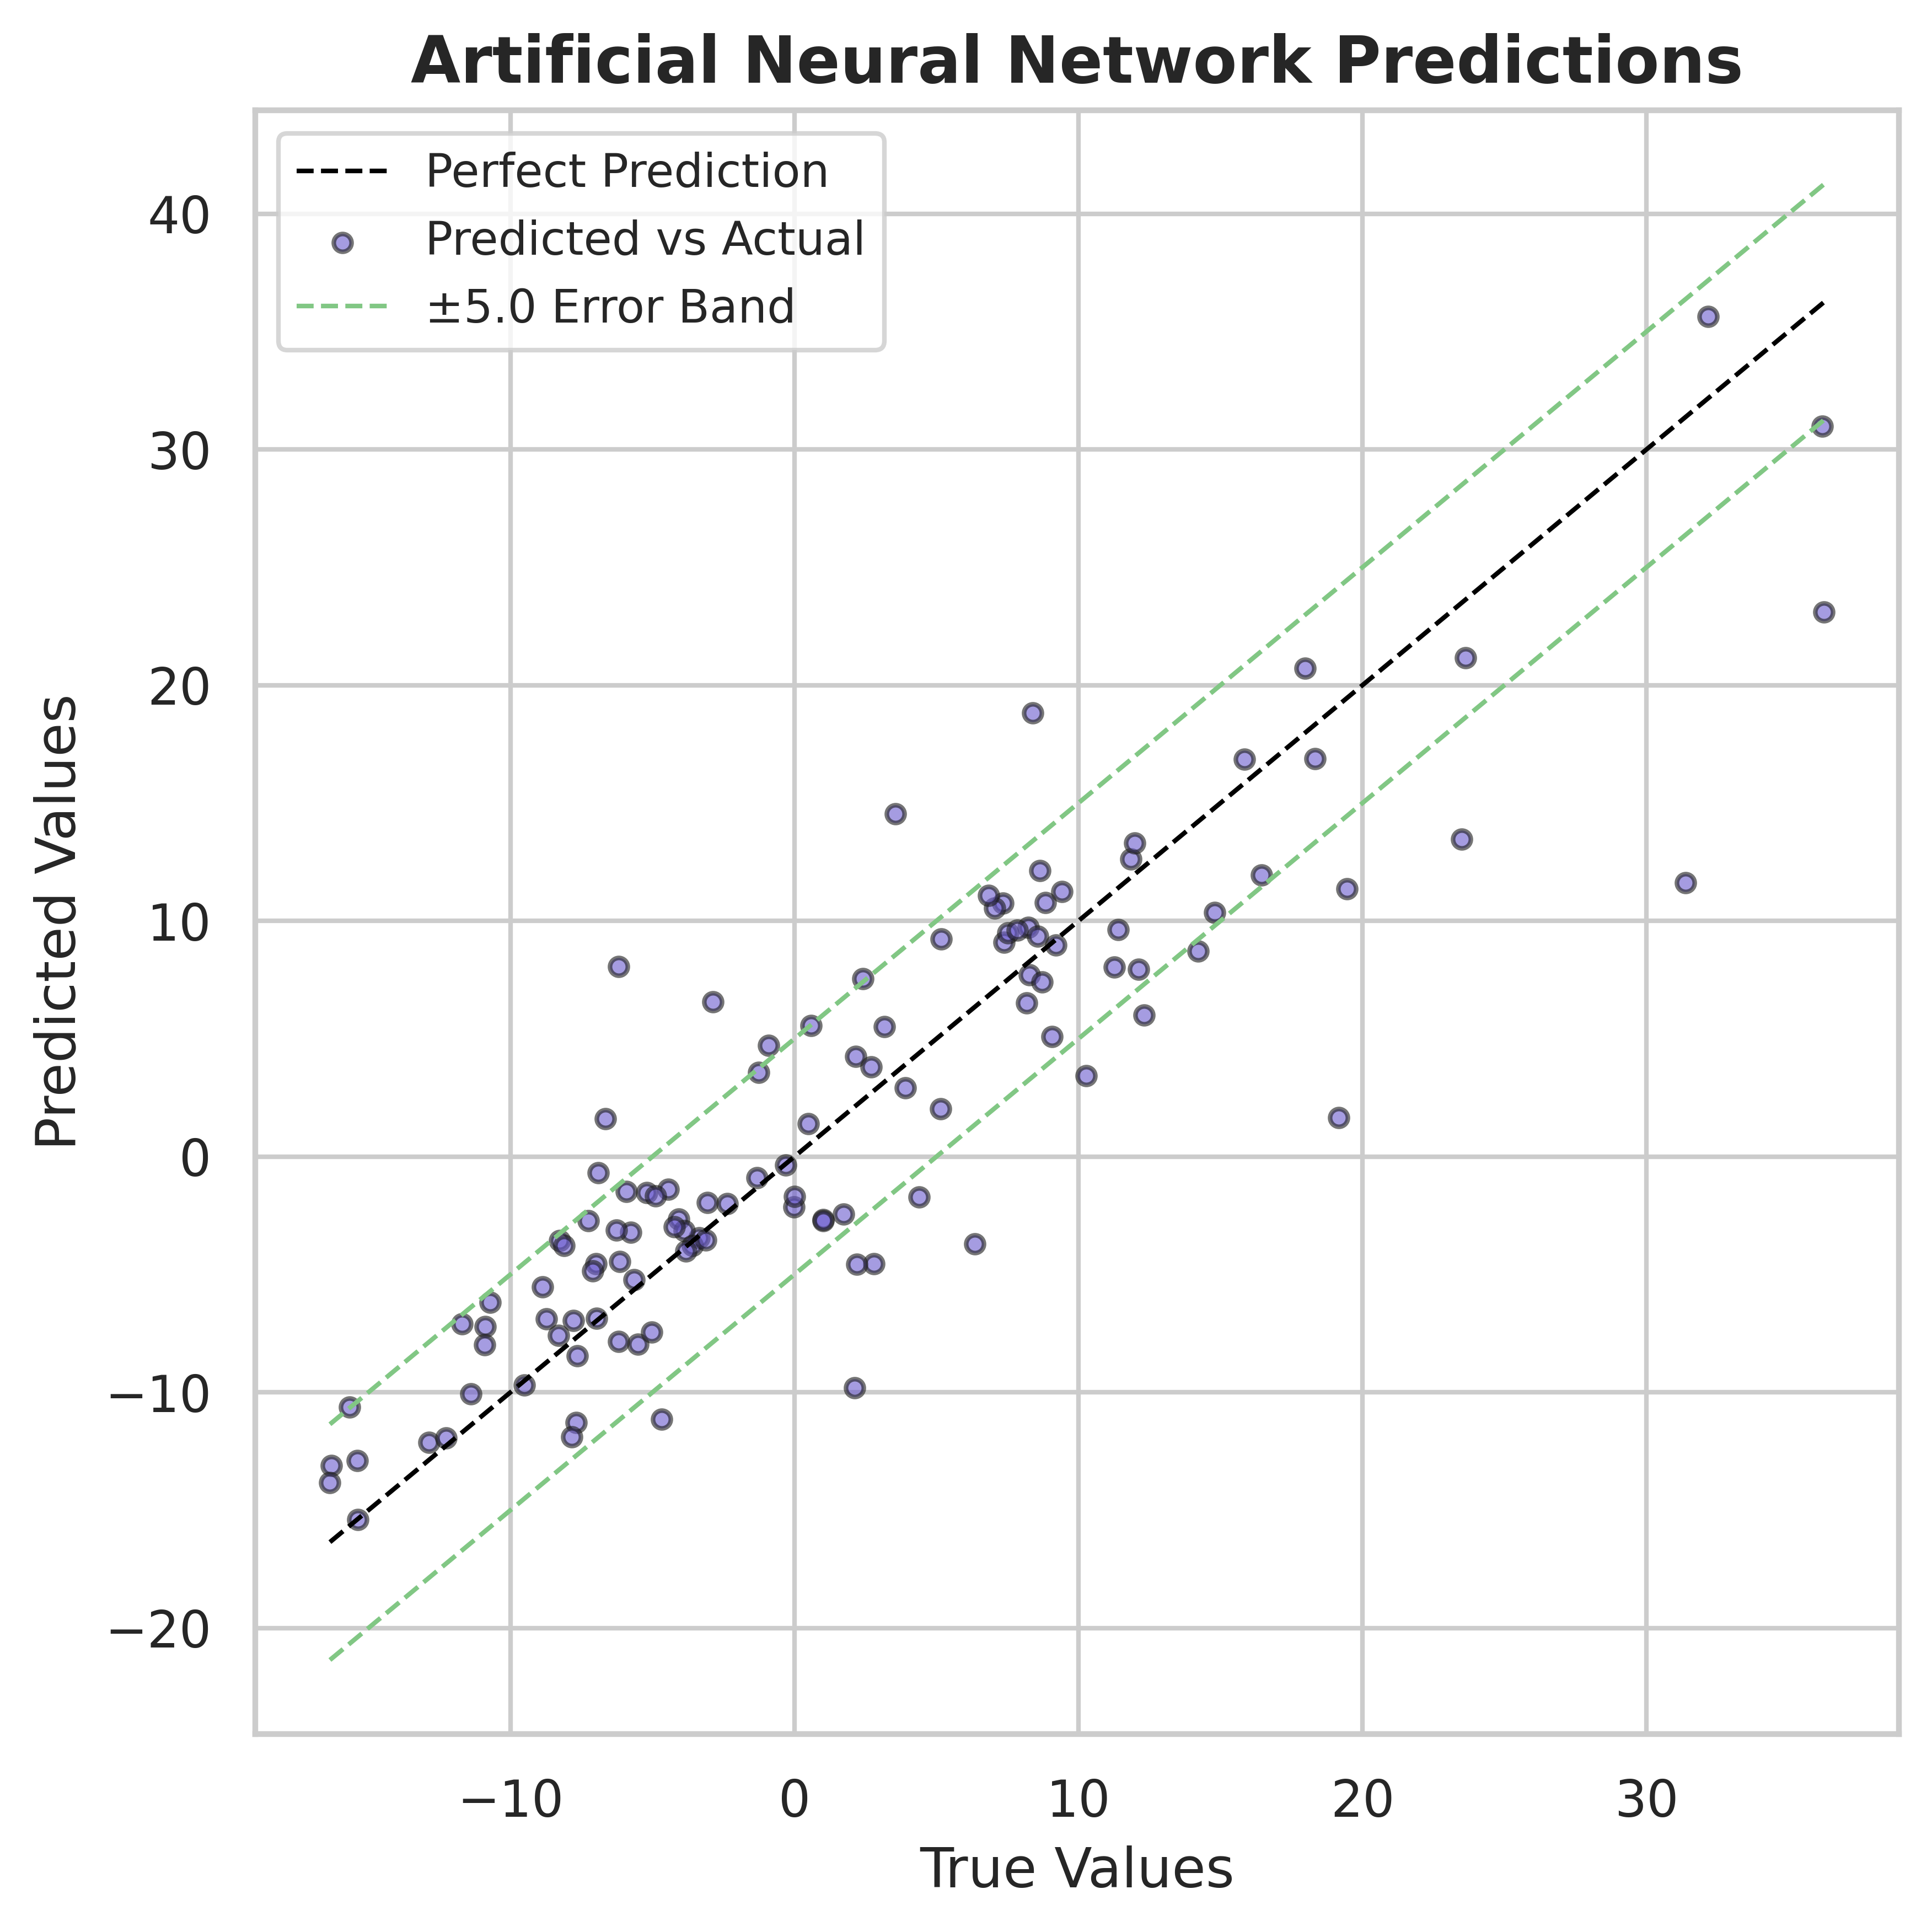

In [50]:
import seaborn as sns

# Optional: use seaborn style for aesthetics
sns.set(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

# Compute min and max for diagonal and offset lines
min_y = min(min(y_train), min(y_train_pred))
max_y = max(max(y_train), max(y_train_pred))

# Plotting
ax.plot([min_y, max_y], [min_y, max_y], label="Perfect Prediction", color="black", linestyle="--", linewidth=1)

ax.scatter(y_train, y_train_pred, c="#6a5acd", s=15, alpha=0.6, edgecolor="k", label="Predicted vs Actual")

ax.plot([min_y, max_y], [min_y+5, max_y+5], linestyle="--", color="#81c784", linewidth=1, label="±5.0 Error Band")
ax.plot([min_y, max_y], [min_y-5, max_y-5], linestyle="--", color="#81c784", linewidth=1)

# Labels and Title
ax.set_xlabel("True Values", fontsize=12)
ax.set_ylabel("Predicted Values", fontsize=12)
ax.set_title("Artificial Neural Network Predictions", fontsize=14, weight="bold")

# Grid and Legend
ax.legend(loc="upper left", fontsize=10)
# ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Improve layout
plt.tight_layout()

# Save in high-quality formats
# plt.savefig("neural_network_cte.svg", bbox_inches='tight')
# plt.savefig("neural_network_cte.png", dpi=600, bbox_inches='tight')

plt.show()

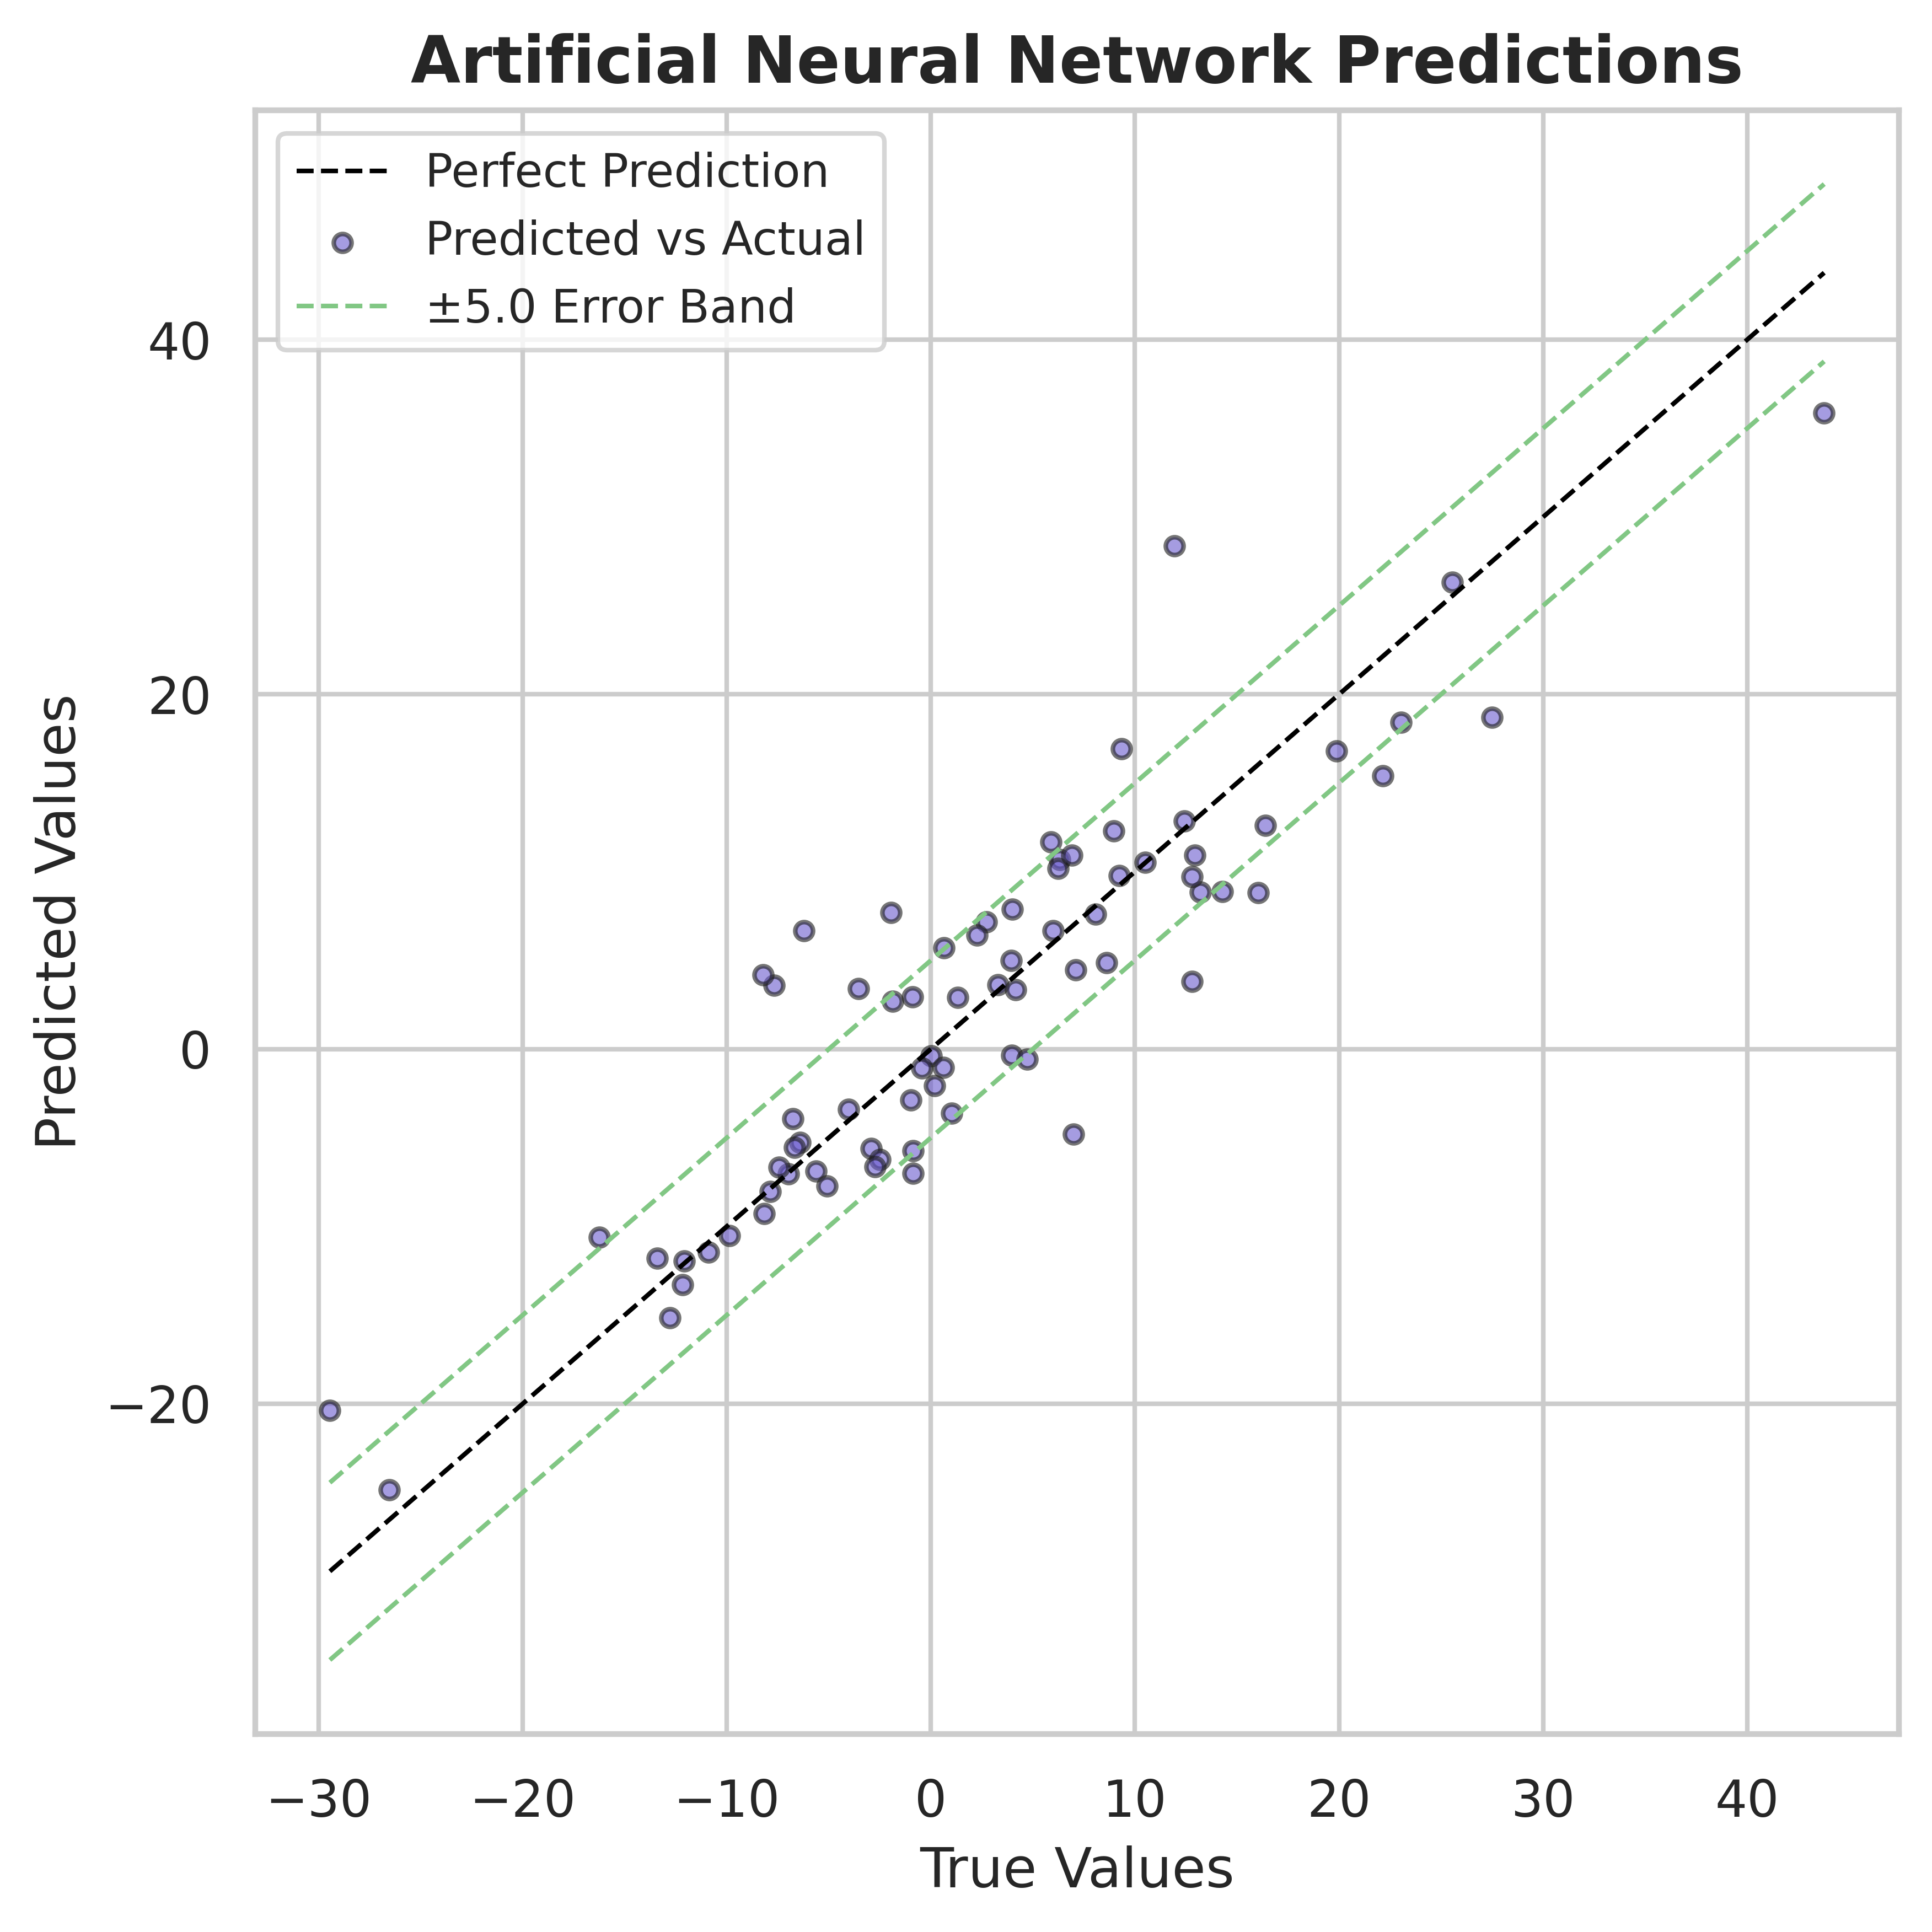

In [51]:
import seaborn as sns

# Optional: use seaborn style for aesthetics
sns.set(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

# Compute min and max for diagonal and offset lines
min_y = min(min(y_test), min(y_pred))
max_y = max(max(y_test), max(y_pred))

# Plotting
ax.plot([min_y, max_y], [min_y, max_y], label="Perfect Prediction", color="black", linestyle="--", linewidth=1)

ax.scatter(y_test, y_pred, c="#6a5acd", s=15, alpha=0.6, edgecolor="k", label="Predicted vs Actual")

ax.plot([min_y, max_y], [min_y+5, max_y+5], linestyle="--", color="#81c784", linewidth=1, label="±5.0 Error Band")
ax.plot([min_y, max_y], [min_y-5, max_y-5], linestyle="--", color="#81c784", linewidth=1)

# Labels and Title
ax.set_xlabel("True Values", fontsize=12)
ax.set_ylabel("Predicted Values", fontsize=12)
ax.set_title("Artificial Neural Network Predictions", fontsize=14, weight="bold")

# Grid and Legend
ax.legend(loc="upper left", fontsize=10)
# ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Improve layout
plt.tight_layout()

# Save in high-quality formats


plt.show()

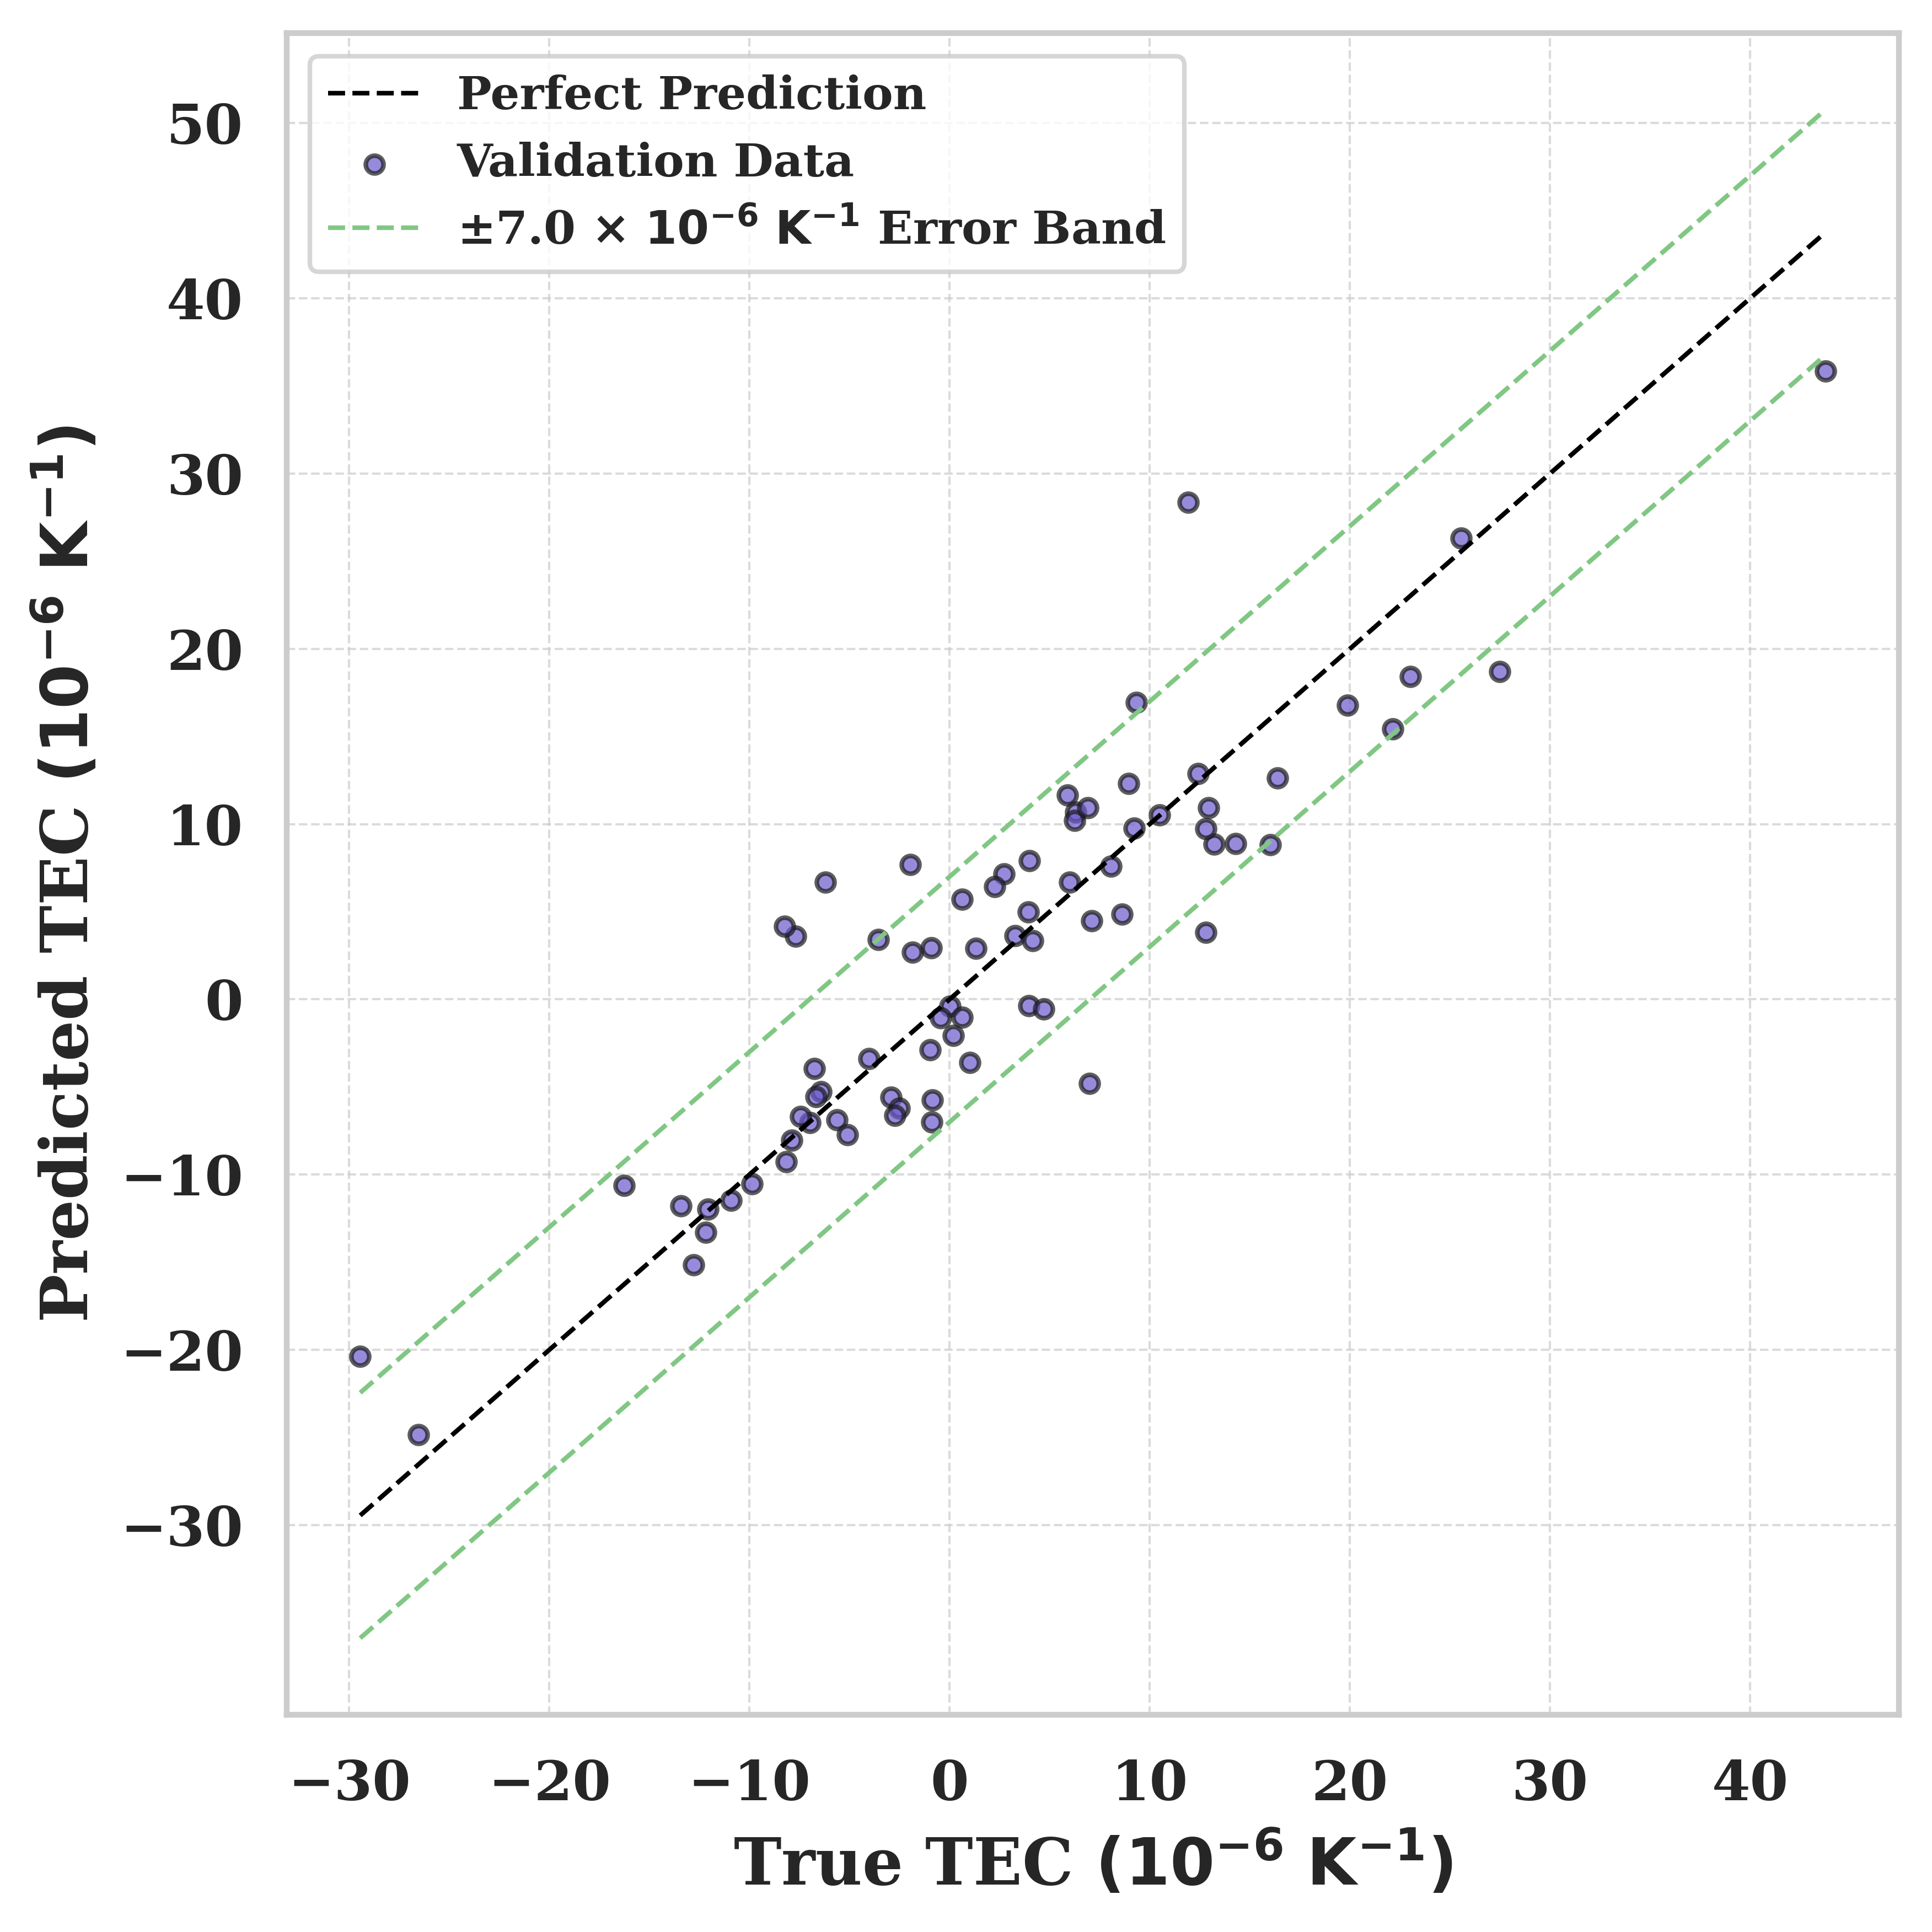

In [52]:
import seaborn as sns

# Optional: use seaborn style for aesthetics
sns.set(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

# Compute min and max for diagonal and offset lines
min_y = min(min(y_train), min(y_test), min(y_train_pred), min(y_pred))
max_y = max(max(y_train), max(y_test), max(y_train_pred), max(y_pred))

# Plotting
ax.plot(np.array([min_y, max_y]), np.array([min_y, max_y]), label="Perfect Prediction", color="black", linestyle="--", linewidth=1)

# ax.scatter(y_train, y_train_pred, c="#6a5acd", marker='d', s=15, alpha=0.7, edgecolor="k", label="Training Data")
ax.scatter(y_test, y_pred, c="#6a5acd", s=15, alpha=0.7, edgecolor="k", label="Validation Data")

ax.plot([min_y, max_y], [min_y+7, max_y+7], 
        linestyle="--", 
        color="#81c784", 
        linewidth=1, 
        label= r"±7.0 " + r"$\mathbf{\times\ 10^{-6}\ K^{-1}}$" + r" Error Band")

ax.plot([min_y, max_y], [min_y-7, max_y-7], linestyle="--", color="#81c784", linewidth=1)

# Labels and Title
ax.set_xlabel(
    r"True TEC " + r"$\mathbf{(10^{-6}\ K^{-1})}$",
    fontsize=14,
    fontweight='bold',
    fontfamily="serif"
)

ax.set_ylabel(
    r"Predicted TEC " + r"$\mathbf{(10^{-6}\ K^{-1})}$",
    fontsize=14,
    fontweight="bold",
    fontfamily="serif"
)

ax.set_yticks(np.arange(-30, 60, 10))
ax.set_yticks(np.arange(-30, 60, 10))

for text in ax.get_yticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# Grid and Legend
legend = ax.legend(loc="upper left", fontsize=10)
for text in legend.get_texts():
    text.set_fontfamily('serif')     # or 'Times New Roman', etc.
    text.set_fontweight('bold')
    text.set_fontstyle('normal')     # optional: italic, normal, oblique
    
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Improve layout
plt.tight_layout()

# Save in high-quality formats
plt.savefig("neural_network_cte.svg", bbox_inches='tight')
plt.savefig("neural_network_cte.png", dpi=600, bbox_inches='tight')

plt.show()

In [53]:
import numpy as np
from scipy.stats import ttest_rel

# Assume y_test are true values, y_pred are model predictions
y_mean_pred = np.mean(y_train) # Null model prediction (mean of y_test)

# Compute absolute errors
errors_model = np.abs(y_test - y_pred)
errors_null = np.abs(y_test - y_mean_pred)

print(np.mean(errors_model), np.mean(errors_null))

# Perform paired t-test
t_stat, p_value = ttest_rel(errors_null, errors_model)

print(f"T-statistic: {t_stat}, p-value: {p_value}")

3.8997486 8.875568
T-statistic: 5.442492126400564, p-value: 6.524518326578403e-07


In [54]:
feature_names

Index(['atom_types', 'mean_coordination', 'bond_types', 'mean_bond_length',
       'types_of_bond_angle', 'symmetry_number', 'types_puckering',
       'mean_puckering', 'bond_density', 'z_variance', 'oxidation', 'entropy',
       'predicted_nte_max'],
      dtype='object')

In [55]:
feature_names = ['A_typ', r'$\overline{\mathbf{C.N}}$', 'B_typ', r'$\bar{\mathbf{x}}$', 'BA_typ', 'symm', 
                 'h_typ', r'$\bar{\mathbf{h}}$', 'BD', 'z_var', 'ox_state', 'CE', r"ML " + r"$\mathbf{\alpha_{max}}$"]

In [56]:
import shap

# Define a simple prediction function using your PyTorch model
def model_predict(x_numpy):
    x_tensor = torch.from_numpy(x_numpy.astype(np.float32))
    with torch.no_grad():
        preds = model(x_tensor).numpy().flatten()
    return preds

# Use KernelExplainer with a background sample (e.g., 100 random points)
X_train_df = pd.DataFrame(X_train.numpy(), columns=feature_names)
background = shap.sample(X_train_df, len(X_train_df))

X_test_df = pd.DataFrame(X_test.numpy(), columns=feature_names)
# X_test_df = pd.DataFrame(X_test.numpy(), columns=feature_names)

# X_test_df = pd.DataFrame(X_val_df, ignore_index=True)

explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(X_test_df)

Using 113 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/75 [00:00<?, ?it/s]

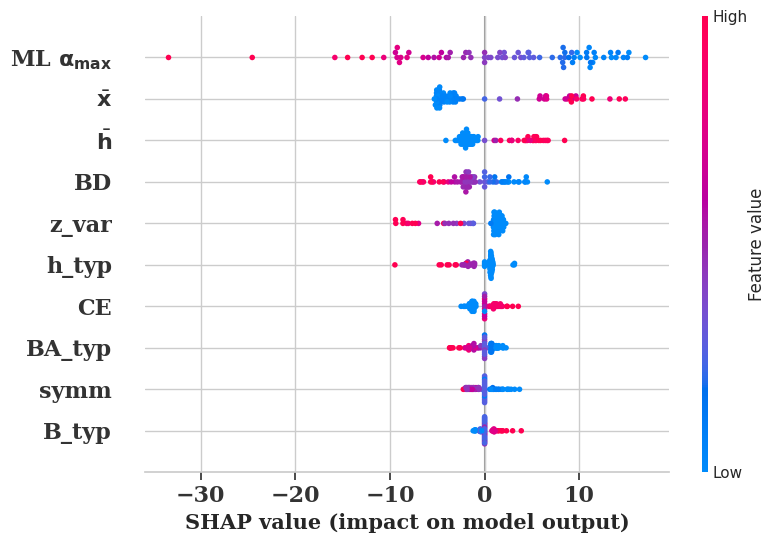

In [57]:
shap.summary_plot(shap_values, X_test_df, max_display=10, show=False)

ax = plt.gca()

# Modify feature names (y-axis labels)
for text in ax.get_yticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# Modify axis labels and title
ax.set_xlabel(ax.get_xlabel(), fontsize=15, fontweight='bold', fontfamily='serif')
ax.set_title(ax.get_title(), fontsize=20, fontweight='bold')

plt.savefig("shap_summary_tec.png", dpi=600, bbox_inches="tight")  # Save as PNG
plt.savefig("shap_summary_tec.svg", dpi=600, bbox_inches="tight")

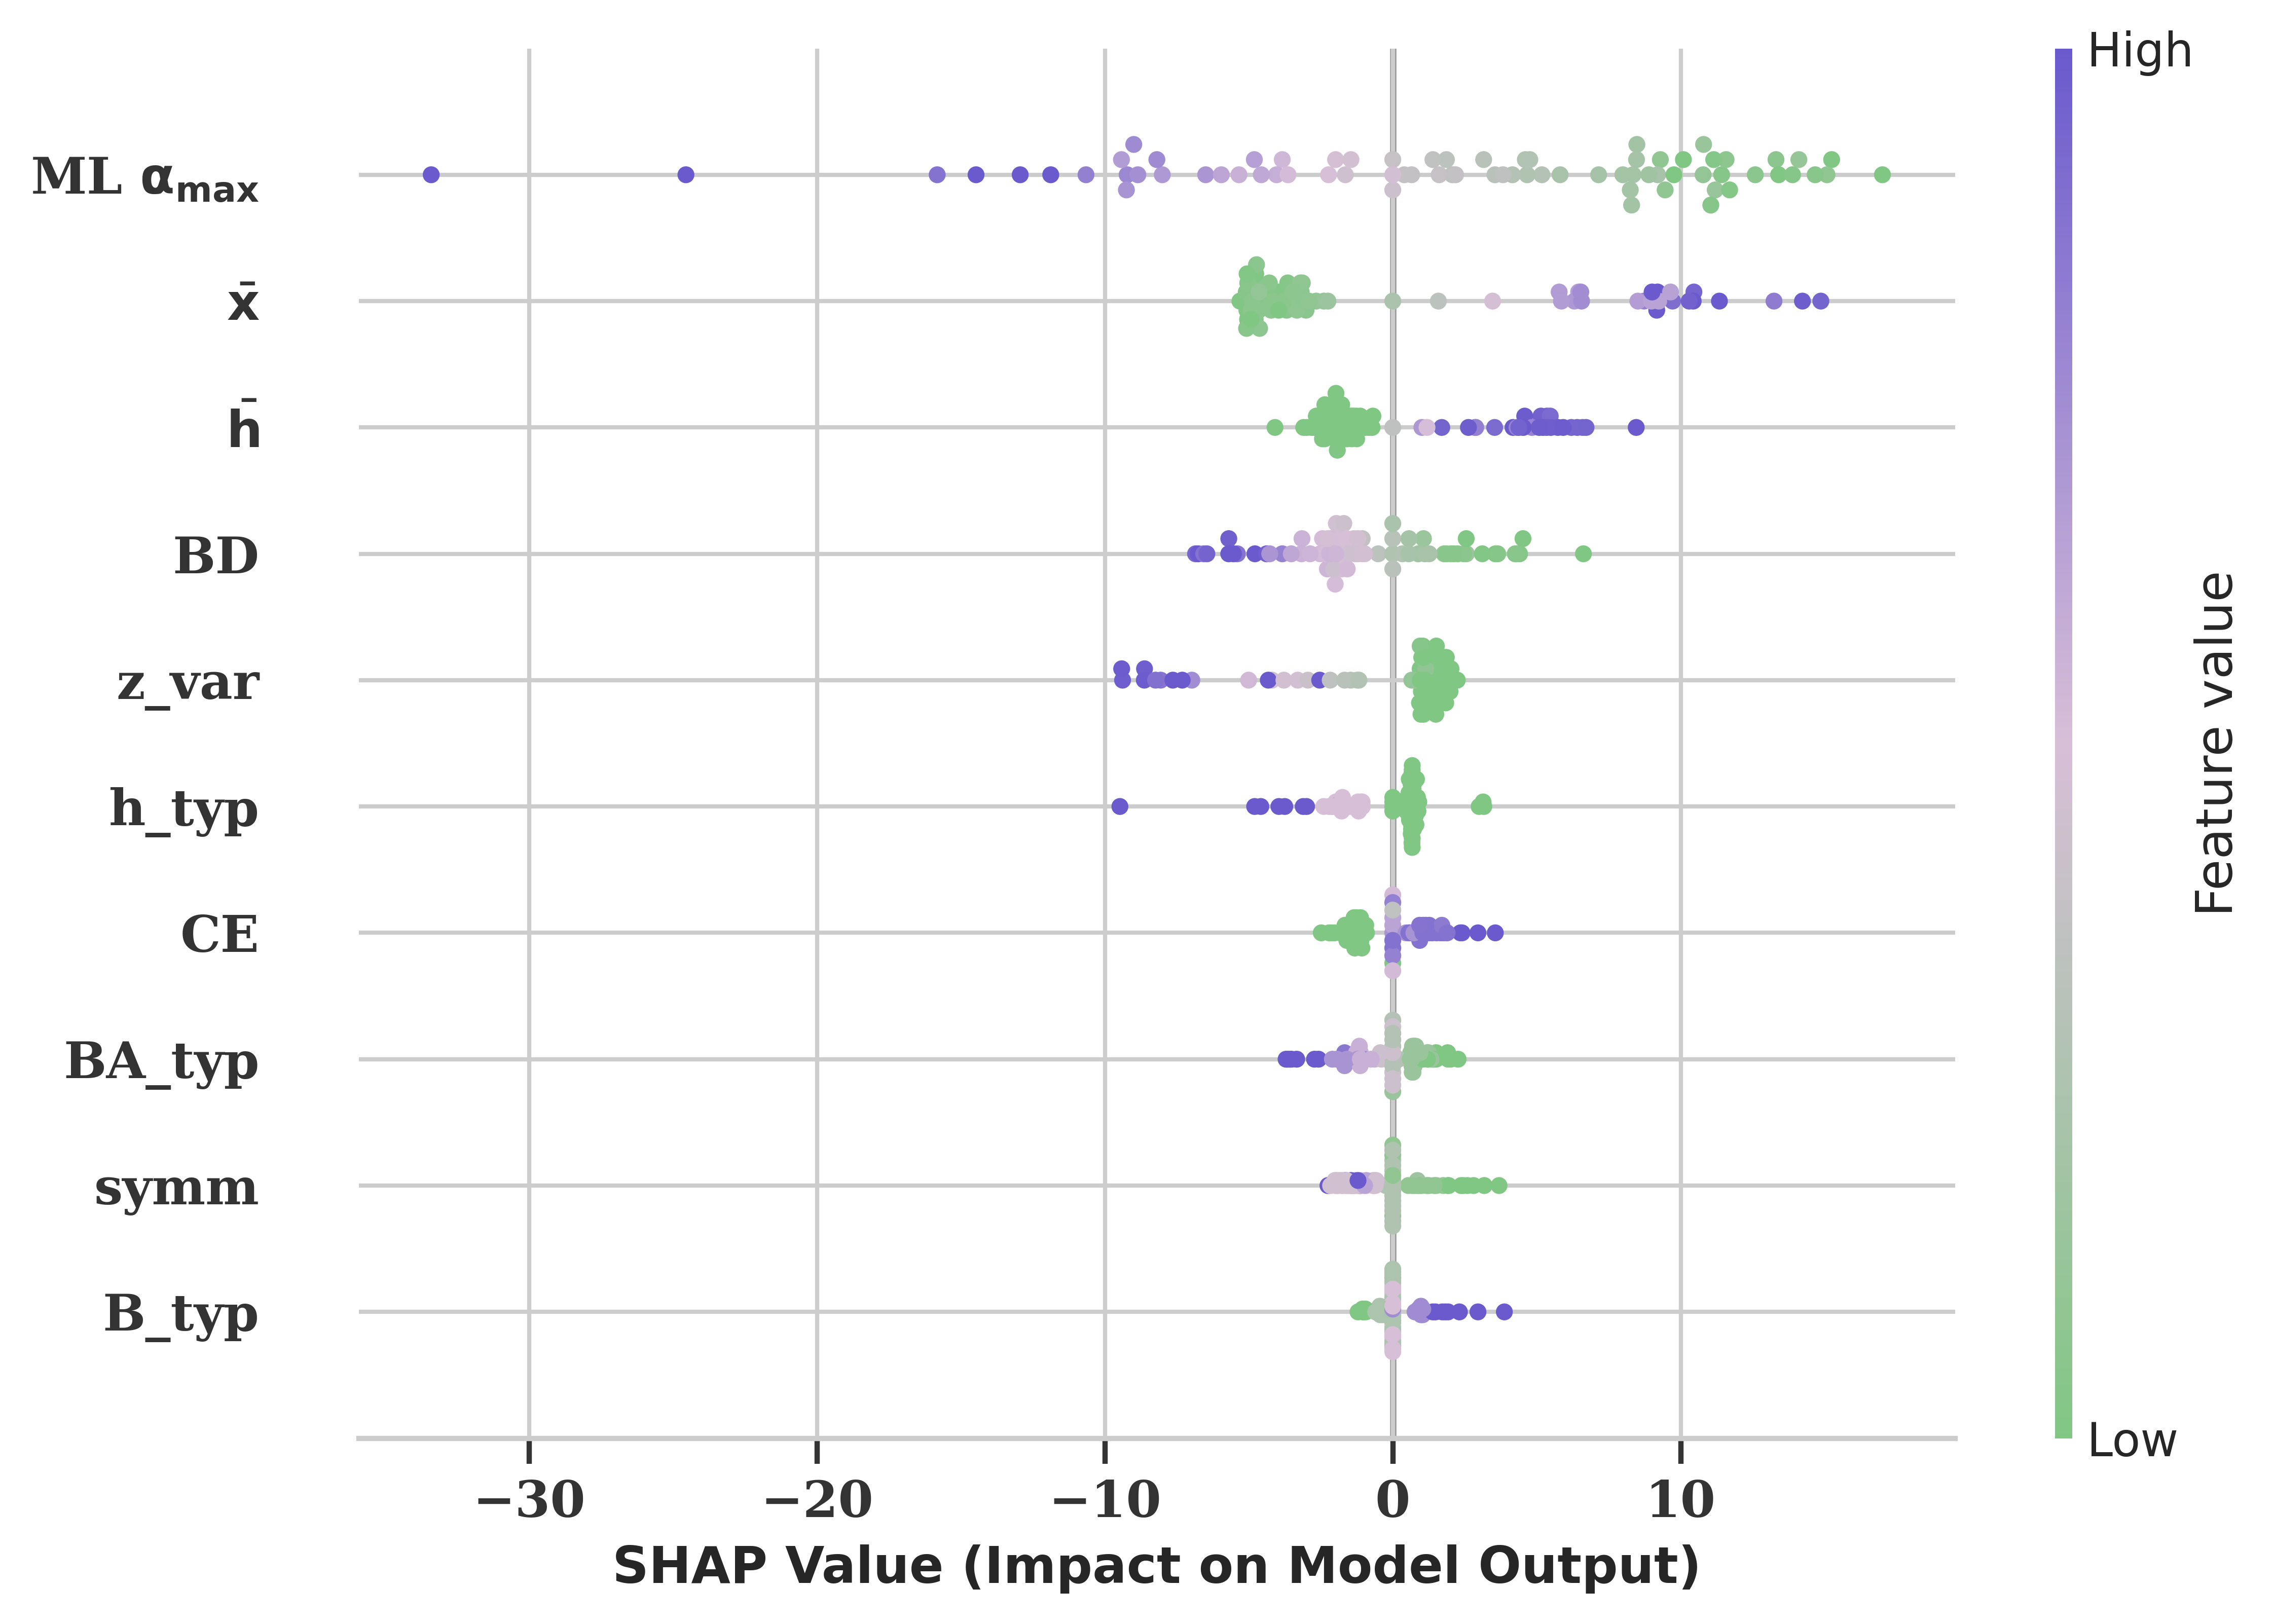

In [58]:
import shap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define custom cmap
purple_green_cmap = LinearSegmentedColormap.from_list(
    "purple_green",
    [   "#81c784",  # Soft Green
        "#d8bfd8",  # Thistle
     "#6a5acd",  # Slate Blue
    ]
)

# Create SHAP summary plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

shap.summary_plot(
    shap_values,
    X_test_df,
    feature_names=feature_names,
    max_display=10,
    show=False,
    cmap=purple_green_cmap
)

for text in ax.get_yticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# plt.title("SHAP Feature Importance", fontsize=14, weight="bold")
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12, weight='bold')
plt.tight_layout()
# plt.savefig("shap_summary_tec.svg", dpi=600)
plt.show()

In [59]:
def print_errors(errors, labels, tol=10.0):
    assert len(errors) == len(labels)
    i = 0
    for error in errors:
        if abs(error) > tol:
            print(f"{labels[i]}: {error:.4f}")
        i += 1

In [60]:
train_errors = y_train_pred - y_train
val_errors = y_pred - y_test

print_errors(train_errors, train_labels, tol=10)
print("-"*50)
print_errors(val_errors, test_labels, tol=10)

GaSb: -10.0237
C4N3: -19.7670
BSb: -11.9265
InAs: 10.9949
BC6N-Rec: -10.0449
BaAs3: 10.4268
squarographene: -17.5119
C9N4: 14.2658
CaP3: -13.1578
--------------------------------------------------
12: 12.8956
pza_c10: 11.2930
CN: -11.7873
B2N2: 12.4043
black-P: 16.4400
